In [1]:
import time
import torch
import numpy as np
import torch.optim as optim

from utils import DepthLoss
from resnet_model import ResnetModel
from utils import prepare_dataloader
import collections
import matplotlib.pyplot as plt
import matplotlib as mpl
from easydict import EasyDict as edict
mpl.rcParams['figure.figsize'] = (15, 10)


In [4]:
def adjust_learning_rate(optimizer, epoch, learning_rate):

    if epoch >= 30 and epoch < 40:
        lr = learning_rate / 2
    elif epoch >= 40:
        lr = learning_rate / 4
    else:
        lr = learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [5]:
def post_process_disparity(disp):
    (_, h, w) = disp.shape
    l_disp = disp[0, :, :]
    r_disp = np.fliplr(disp[1, :, :])
    m_disp = 0.5 * (l_disp + r_disp)
    (l, _) = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
    l_mask = 1.0 - np.clip(20 * (l - 0.05), 0, 1)
    r_mask = np.fliplr(l_mask)
    return r_mask * l_disp + l_mask * r_disp + (1.0 - l_mask - r_mask) * m_disp


In [2]:
torch.cuda.is_available()

True

In [ ]:
def get_model(input_channels=3, pretrained=False):
    return ResnetModel(input_channels, pretrained=pretrained)

In [ ]:
def to_device(input, device):
    if torch.is_tensor(input):
        return input.to(device=device)
    elif isinstance(input, str):
        return input
    elif isinstance(input, collections.abc.Mapping):
        return {k: to_device(sample, device=device) for k, sample in input.items()}
    elif isinstance(input, collections.Sequence):
        return [to_device(sample, device=device) for sample in input]

In [6]:
class Model:

    def __init__(self, args):
        self.args = args

        # Set up model
        self.device = args.device
        self.model = get_model(input_channels=3, pretrained=True)
        self.model = self.model.to(self.device)
        if args.mode == 'train':
            self.loss_function = DepthLoss(
                n=4,
                SSIM_w=0.85,
                disp_gradient_w=0.1, lr_w=1).to(self.device)
            self.learning_rate = 1e-4
            self.augment_parameters = [0.8, 1.2, 0.5, 2.0, 0.8, 1.2]
            self.num_workers = 8
            self.batch_size = 8
            self.do_augmentation = True
            self.optimizer = optim.Adam(self.model.parameters(),
                                        lr=self.learning_rate)
            self.val_n_img, self.val_loader = prepare_dataloader(args.val_data_dir, args.mode,
                                                                 self.augment_parameters,
                                                                 False, self.batch_size,
                                                                 (args.input_height, args.input_width),
                                                                 self.num_workers)
        else:
            self.model.load_state_dict(torch.load(args.model_path))
            self.augment_parameters = None
            self.do_augmentation = False
            self.batch_size = 1
            self.num_workers = 4

        # Load data
        self.output_directory = args.output_directory
        self.input_height = args.input_height
        self.input_width = args.input_width

        self.n_img, self.loader = prepare_dataloader(args.data_dir, args.mode, self.augment_parameters,
                                                     self.do_augmentation, self.batch_size,
                                                     (args.input_height, args.input_width),
                                                     self.num_workers)

        torch.cuda.synchronize()


    def train(self):
        losses = []
        val_losses = []
        best_loss = float('Inf')
        best_val_loss = float('Inf')

        running_val_loss = 0.0
        self.model.eval()
        for data in self.val_loader:
            data = to_device(data, self.device)
            left = data['left_image']
            right = data['right_image']
            disps = self.model(left)
            loss = self.loss_function(disps, [left, right])
            val_losses.append(loss.item())
            running_val_loss += loss.item()

        running_val_loss /= self.val_n_img / self.batch_size
        print('Val_loss:', running_val_loss)

        for epoch in range(self.args.epochs):
            adjust_learning_rate(self.optimizer, epoch,
                                     self.learning_rate)
            c_time = time.time()
            running_loss = 0.0
            self.model.train()
            for data in self.loader:
                # Load data
                data = to_device(data, self.device)
                left = data['left_image']
                right = data['right_image']

                # One optimization iteration
                self.optimizer.zero_grad()
                disps = self.model(left)
                loss = self.loss_function(disps, [left, right])
                loss.backward()
                self.optimizer.step()
                losses.append(loss.item())

                running_loss += loss.item()

            running_val_loss = 0.0
            self.model.eval()
            for data in self.val_loader:
                data = to_device(data, self.device)
                left = data['left_image']
                right = data['right_image']
                disps = self.model(left)
                loss = self.loss_function(disps, [left, right])
                val_losses.append(loss.item())
                running_val_loss += loss.item()

            # Estimate loss per image
            running_loss /= self.n_img / self.batch_size
            running_val_loss /= self.val_n_img / self.batch_size
            print (
                'Epoch:',
                epoch + 1,
                'train_loss:',
                running_loss,
                'val_loss:',
                running_val_loss,
                'time:',
                round(time.time() - c_time, 3),
                's',
                )
            self.save(self.args.model_path[:-4] + '_last.pth')
            if running_loss < best_loss:
                best_loss = running_loss
            if running_val_loss < best_val_loss:
                self.save(self.args.model_path[:-4] + '_cpt.pth')
                best_val_loss = running_val_loss
                print('Model_saved')

        print ('Finished Training. Best loss:', best_loss)
        self.save(self.args.model_path)
        return losses, val_losses

    def save(self, path):
        torch.save(self.model.state_dict(), path)

    def load(self, path):
        self.model.load_state_dict(torch.load(path))

    def test(self):
        self.model.eval()
        disparities = np.zeros((self.n_img,
                               self.input_height, self.input_width),
                               dtype=np.float32)
        disparities_pp = np.zeros((self.n_img,
                                  self.input_height, self.input_width),
                                  dtype=np.float32)
        with torch.no_grad():
            for (i, data) in enumerate(self.loader):
                # Get the inputs
                data = to_device(data, self.device)
                left = data.squeeze()
                # Do a forward pass
                disps = self.model(left)
                disp = disps[0][:, 0, :, :].unsqueeze(1)
                disparities[i] = disp[0].squeeze().cpu().numpy()
                disparities_pp[i] = \
                    post_process_disparity(disps[0][:, 0, :, :]\
                                           .cpu().numpy())

        np.save(self.output_directory + '/disparities.npy', disparities)
        np.save(self.output_directory + '/disparities_pp.npy',
                disparities_pp)
        print('Finished Testing')


In [6]:
dict_parameters = edict({'data_dir':'/home/labmember/Desktop/project/new_dataset/train/',
                         'val_data_dir':'/home/labmember/Desktop/project/new_dataset/val/',
                         'model_path':'data/models/monodepth_resnet18_001.pth',
                         'output_directory':'data/output/',
                         'input_height':256,
                         'input_width':512,
                         'model':'resnet18_md',
                         'mode':'train',
                         'epochs':65,
                         'device':'cuda:0'})

In [7]:
import gc
gc.collect()
torch.cuda.empty_cache()
# torch.cuda.memory_allocated()

In [8]:
model = Model(dict_parameters)

/home/labmember/Desktop/project/Code/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/labmember/Desktop/project/Code/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Use a dataset with 4635 images
Use a dataset with 17923 images


In [9]:
train_loss, val_loss = model.train()

/home/labmember/Desktop/project/Code/.venv/lib/python3.10/site-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Val_loss: 2.68397910520354
Epoch: 1 train_loss: 1.3533281824494727 val_loss: 1.4609942830239042 time: 810.837 s
Model_saved
Epoch: 2 train_loss: 1.0706347281835857 val_loss: 1.6117145581538623 time: 773.569 s
Epoch: 3 train_loss: 0.9698166798808336 val_loss: 1.3646811093327298 time: 781.899 s
Model_saved
Epoch: 4 train_loss: 0.9144889358191034 val_loss: 1.1756843639937549 time: 782.997 s
Model_saved
Epoch: 5 train_loss: 0.8744269851355096 val_loss: 1.1832691231720398 time: 782.902 s
Epoch: 6 train_loss: 0.8458013038899174 val_loss: 1.3892499304383574 time: 772.298 s
Epoch: 7 train_loss: 0.8274577066634028 val_loss: 1.0436858045501873 time: 778.745 s
Model_saved
Epoch: 8 train_loss: 0.8110834821781822 val_loss: 1.1846704299910298 time: 783.794 s
Epoch: 9 train_loss: 0.8000417504866382 val_loss: 1.1590389264054284 time: 778.385 s
Epoch: 10 train_loss: 0.7870010853425631 val_loss: 0.9771666003148018 time: 784.051 s
Model_saved
Epoch: 11 train_loss: 0.7763066383329466 val_loss: 0.942084044

In [20]:
new_train_loss = []
new_val_loss = []
for i in train_loss[::2241]:
    new_train_loss.append(i)
for i in val_loss[::588]:
    new_val_loss.append(i)

In [27]:
%matplotlib inline

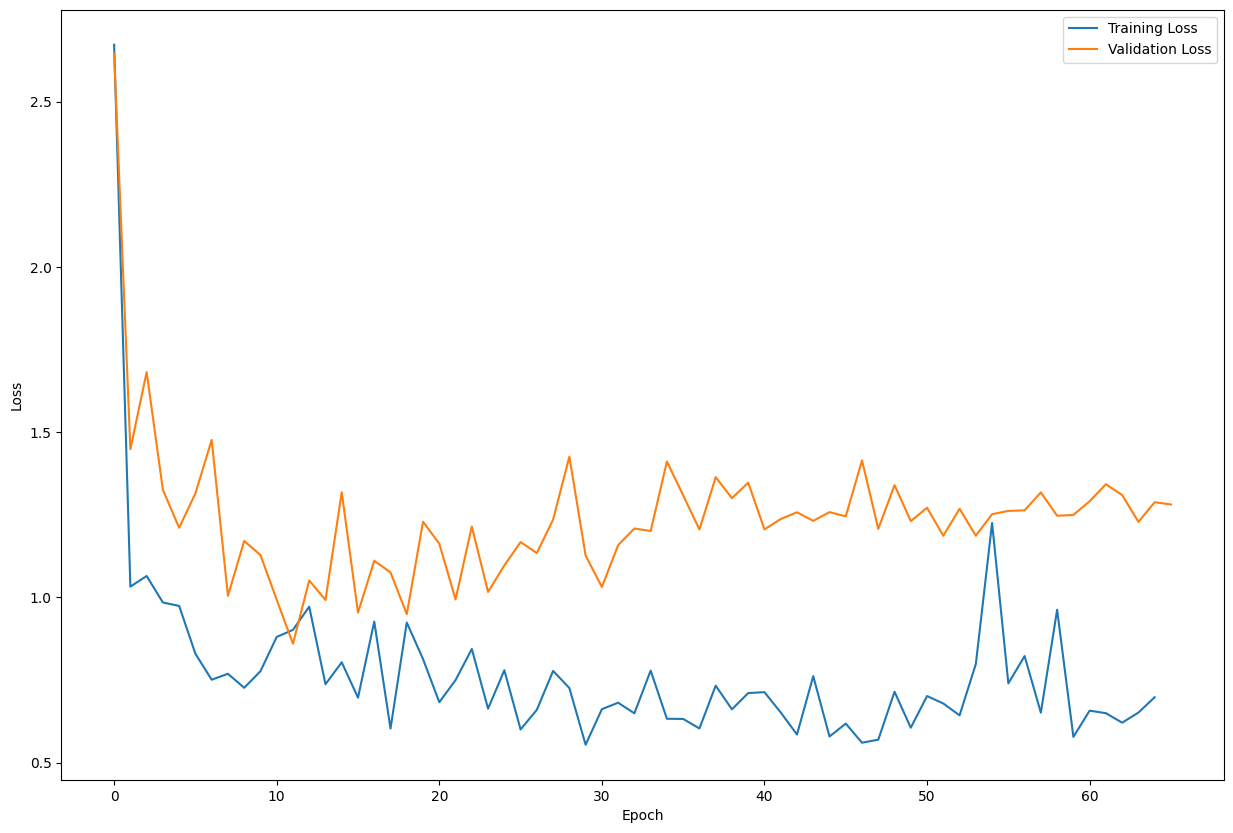

In [31]:
plt.figure(figsize=(15, 10))
plt.plot(new_train_loss, label='Training Loss')
plt.plot(new_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
plt.savefig('loss_plot.png', dpi=300)

<Figure size 1500x1000 with 0 Axes>

In [7]:
dict_parameters_test = edict({'data_dir':'/home/labmember/Desktop/project/dataset/test',
                              'model_path':'data/models/monodepth_resnet18_001.pth',
                              'output_directory':'data/output/',
                              'input_height':256,
                              'input_width':512,
                              'model':'resnet18_md',
                              'pretrained':False,
                              'mode':'test',
                              'device':'cuda:0'})
model_test = Model(dict_parameters_test)

/home/labmember/Desktop/project/Code/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/labmember/Desktop/project/Code/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Use a dataset with 10 images


In [12]:
model_test.test()

Finished Testing


In [13]:
disp = np.load('data/output/disparities.npy')  # Or disparities.npy for output without post-processing
disp.shape

(10, 256, 512)

In [14]:
import skimage

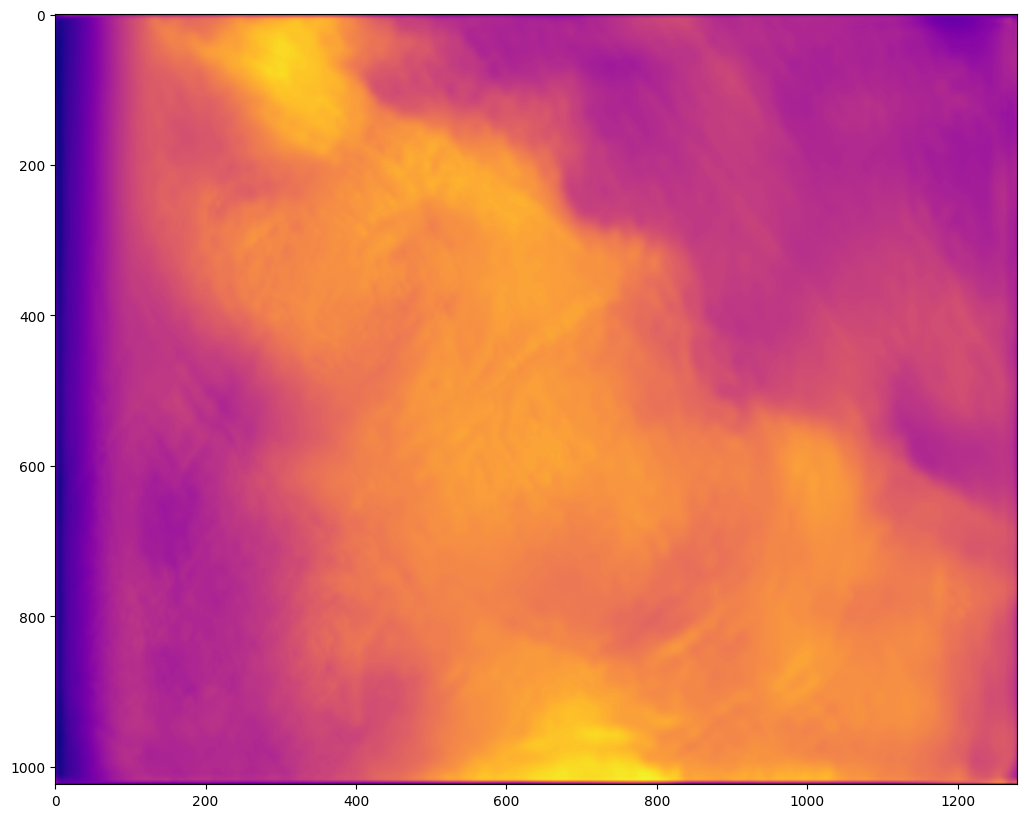

In [65]:
disp_to_img = skimage.transform.resize(disp[6].squeeze(), [1024, 1280], mode='constant')
plt.imshow(disp_to_img, cmap='plasma')
plt.savefig('data/output/depth_map.png')

In [66]:
plt.imsave('depth_image_saved_7.jpg', disp_to_img, cmap="plasma")

In [32]:
import open3d as o3d

RGBDImage of size 
Color image : 1280x1024, with 3 channels.
Depth image : 1280x1024, with 1 channels.
Use numpy.asarray to access buffer data.


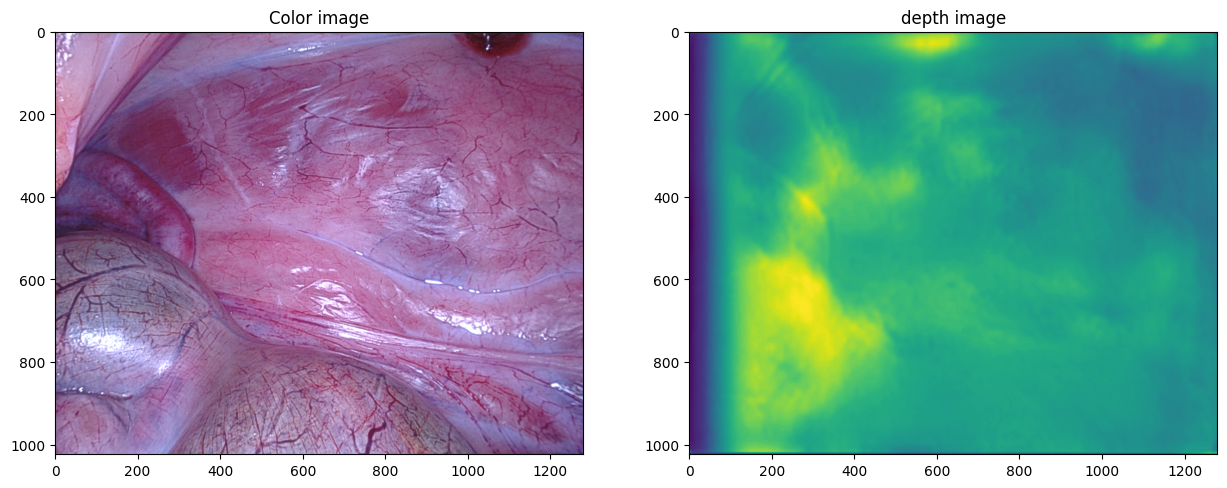

PointCloud with 1310720 points.


In [50]:
color_raw = o3d.io.read_image("/home/labmember/Desktop/project/dataset/test/images/image01/Left_Image6.png")
depth_raw = o3d.io.read_image("depth_image_saved.jpg")

# create an rgbd image object:
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw, convert_rgb_to_intensity=False)
# use the rgbd image to create point cloud:
def to_3D(fx, fy, depth, cx, cy, u, v):
    x = (u-cx)*depth/fx
    y = (v-cy)*depth/fy
    z = depth
    x = np.expand_dims(x, axis = -1)
    y = np.expand_dims(y, axis = -1)
    z = np.expand_dims(z, axis = -1)
    return np.concatenate((x,y,z), axis=-1)

def make_point_cloud(datapath, fx, fy, cx, cy):
    rgbd = datapath
    H = len(rgbd)
    W = len(rgbd[0])
    u = np.arange(W)
    v = np.arange(H)
    u, v = np.meshgrid(u, v)
    xyz = to_3D(fx, fy, rgbd[:,:,3], cx, cy, u, v)
    rgb = rgbd[:,:,:-1]
    point_cloud = np.concatenate((xyz, rgb), axis=-1)
    return point_cloud

print(rgbd_image)

plt.subplot(1, 2, 1)
plt.title('Color image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('depth image')
plt.imshow(rgbd_image.depth)
plt.show()
# print(np.asarray(rgbd_image.color))
# print(np.asarray(rgbd_image.depth))
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        1280, 1024, 765.8236885, 765.8236885, 276.4727783203125, 253.6752815246582))

# visualize:
# o3d.visualization.draw_geometries([pcd])
print(pcd)
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
# print(np.asarray(pcd.points))
o3d.visualization.draw_geometries([pcd])